# Lab 8: Ageostrophic Wind
The ageostrophic wind is just the part of the wind that is not geostrophic. All acceleration in the wind field is due to the ageostrophic wind. In this lab, you’ll see how to pull in data from the NCEP reanalysis product, compute the geostrophic wind, and display the geostrophic and ageostrophic wind for a weather event of your choice.

We start out by telling Jupyter to show us plots in the same window.

In [2]:
%matplotlib inline

Then, we import a few packages. Using "as" means I can refer to the package with a shortcut later in the code, rather than having to write e.g. `matplotlib.pyplot` every single time I want to refer to something in the code. The "from datetime import datetime" means I only want to access the datetime function within the datetime package. netCDF4 is a standard library for reading netCDF files, and numpy is Numerical Python and has a lot of the stuff you'd be used to from Matlab.

In [3]:
import matplotlib.pyplot as plt
from datetime import datetime
import netCDF4
import numpy as np

Next we specify a lat lon box to focus in on. Lat/lon need to be in 0 to 360 rather than -180 to 180, so for 135 W I wrote 360-135.

In [4]:
# This is for the whole US, you can choose a different area
minlat = 23
maxlat = 51
minlon = 360-135 
maxlon = 360-60

Last we specify the date with the format Year, Month, Day, Hour, Second. NCEP is available every 6 hours, so choose 0, 6, 12, or 18 for hour, and is available from 1948 to 2019. We also specify the pressure level we want to display.

In [11]:
date = datetime(2019, 1, 18, 12, 0)
level = 850 # Choose a level in hPa from 1000, 925, 850, 700, 600, 500

Here's where it gets a bit more interesting. Many public datasets have been made available via THREDDS servers. THREDDS servers allow you do use a URL to identify a dataset and load it onto your computer without having to save a copy locally. Within base_url, there are folders for data at pressure levels and data at the surface, with a file for each year. In python, you can make a long string of letters by adding individual strings. And the netCDF4.Dataset function allows you to specify either a URL to a THREDDS server or the path to a saved file on your computer. So what we do here is we send the Dataset function the URL for specific variables at specific years. 

In [12]:
# Load remote dataset from URL
base_url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/'
ds_hgt = netCDF4.Dataset(base_url + 'pressure/' + 'hgt' + '.' + str(date.year) + '.nc')
ds_uwnd = netCDF4.Dataset(base_url + 'pressure/' + 'uwnd' + '.' + str(date.year) + '.nc')
ds_vwnd = netCDF4.Dataset(base_url + 'pressure/' + 'vwnd' + '.' + str(date.year) + '.nc')
ds_slp = netCDF4.Dataset(base_url + 'surface/' + 'slp' + '.' + str(date.year) + '.nc')

We'll want levels, latitudes, and longitudes as vectors. We could pull them out of any of the above files (except ds_slp doesn't have a levels vector), I just used ds_hgt because it was first on the list.

In [13]:
levels = ds_hgt.variables['level'][:]
lats = ds_hgt.variables['lat'][:]
lons = ds_hgt.variables['lon'][:]

Next, we find the indices of the data we want based on the max and min coordinates and the date chosen above. For the time vector, we need to use the function netCDF4.num2date() to convert the date from number of days since some arbitrary starting point into a regular date, and then we can use np.where to find the index where the date matches our date choice. The function np.where takes a vector of Trues and Falses and returns the indices where the vector is True.

In [14]:
idxminlat = np.min(np.where(lats < minlat)) 
idxmaxlat = np.min(np.where(lats < maxlat))
idxminlon = np.min(np.where(lons > minlon))
idxmaxlon = np.min(np.where(lons > maxlon))
idxlevel = np.min(np.where(levels >= level))
idxlevel = np.min(np.where(levels <= 850))
times = netCDF4.num2date(ds_hgt.variables['time'][:], ds_hgt.variables['time'].units)
idxtime = np.min(np.where(times == datetime(2019,1,18,12,0)))

To select data, we have to specify a variable in the dataset, then give it an index range for time, level (if 3d), latitudes, and longitudes. There are some differences in how Numpy and netCDF interpret ranges, which you can worry about later.

In [63]:
uwnd = ds_uwnd.variables['uwnd'][idxtime, idxlevel, idxmaxlat:idxminlat, idxminlon:idxmaxlon]
vwnd = ds_vwnd.variables['vwnd'][idxtime, idxlevel, idxmaxlat:idxminlat, idxminlon:idxmaxlon]
hgt = ds_hgt.variables['hgt'][idxtime, idxlevel, idxmaxlat:idxminlat, idxminlon:idxmaxlon]
pres = ds_slp.variables['slp'][idxtime, idxmaxlat:idxminlat, idxminlon:idxmaxlon]/100 # Convert to mb
lat_sel = lats[idxmaxlat:idxminlat]
lon_sel = lons[idxminlon:idxmaxlon]

Now we plot the initial wind field, surface pressures, and geopotential heights. Surface pressures are typically reported every 2 mb, and geopotential heights every 40 meters.

Text(0.5, 1.0, 'Wind, surface pressure, and geopotential height at 850 mb')

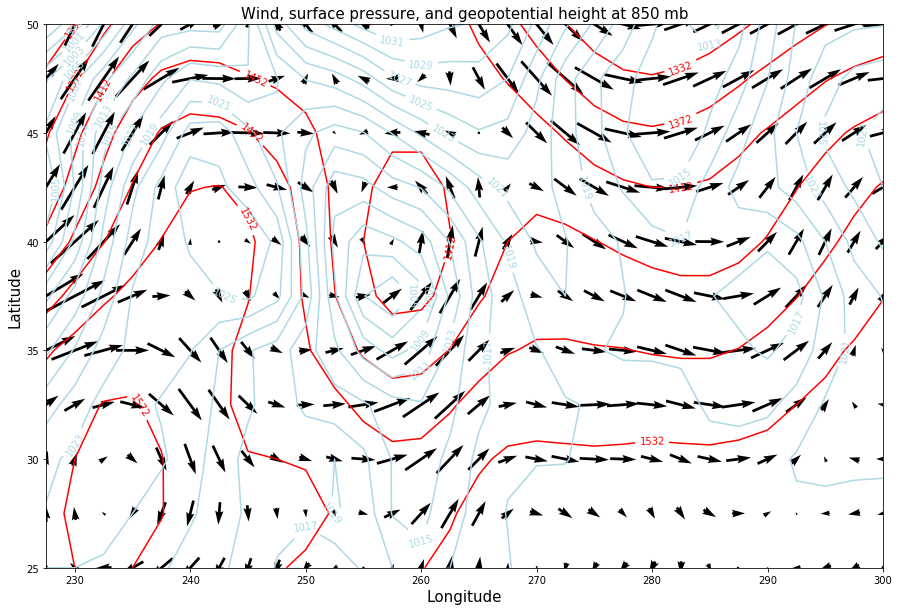

In [69]:
# Plot parameters. The 
hgt_contours = np.arange(hgt.min(), hgt.max() + 1, 40)
pres_contours = np.arange(pres.min(), pres.max()+ 1, 2)



# Plot the wind field
fig = plt.figure(figsize=(15,10))
X, Y = np.meshgrid(lon_sel, lat_sel)
Q = plt.quiver(X, Y, uwnd, vwnd, pivot='mid')
plt.quiverkey(Q, 30, 0.515, 2, 'arrow 1', coordinates='data')

# Plot the geopotential height surface
C1 = plt.contour(X, Y, hgt, levels=hgt_contours, colors='r')
plt.clabel(C1, fmt='%1.f')

C2 = plt.contour(X, Y, pres, levels=pres_contours, colors='lightblue')
plt.clabel(C2, fmt='%1.f')


plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.title('Wind, surface pressure, and geopotential height at 850 mb', fontsize=15)

So what do you notice about the wind vectors? To me it looks like they follow the geopotential height contours pretty well. Let's see how much the wind departs from geostrophy. To do that though we'll need to actually compute the geostrophic wind components in each direction.

# Computing geostrophic wind
We need the form of geostrophic wind that uses geopotential height, since we're looking at data on a single pressure level.
$$ U_g = -\frac{g}{f} \frac{\partial Z}{\partial y} $$
$$ V_g = \frac{g}{f} \frac{\partial Z}{\partial x} $$
We'll use centered differencing to estimate the derivatives, which means we need to grab the data from one cell bigger than the selection we already made. Centered differencing is this, for some function f(x) defined at points i, i+1, etc.
$$ \frac{df}{dx}(x_i) \approx \frac{f(x_{i+1}) - f(x_{i-1})}{x_{i+1} - x_{i-1}} $$
Since we're just going to need the derivatives of geopotential height, we load a slightly bigger section of the geopotential height dataset to allow us to select values surrounding each grid cell.

In [108]:
hgt2 = ds_hgt.variables['hgt'][idxtime, idxlevel, idxmaxlat-1:idxminlat+1, idxminlon-1:idxmaxlon+1]
lat_sel2 = lats[idxmaxlat-1:idxminlat+1].data
lon_sel2 = lons[idxminlon-1:idxmaxlon+1].data

To compute the distance between grid cells, we convert degrees latitude and longitude into radians. The formulas we use are
$$d(\phi_1, \phi_2) = R_E \times (\phi_2 - \phi_1)$$
for latitudes $\phi_1$ and $\phi_2$, and for longitude $\theta_1$ and $\theta_2$ we have
$$d(\theta_1, \theta_2) = R_E \cos (\phi) \times(\theta_1 - \theta_2)$$
where $\phi$ is the latitude.
So first we get the angular differences:

In [143]:
dlat = np.deg2rad(lat_sel2[:-2] - lat_sel2[2:])
dlon = np.deg2rad(lon_sel2[:-2] - lon_sel2[2:])

Then we make an array out of the angular differences, and compute distance in meters. The commands repeat and reshape are used to take a 1D vector and turn it into a 2D array. Multiplication between two arrays in numpy is elementwise rather than matrix multiplication.

In [144]:
# Make into two arrays so that for grid point (i,j), dx is X[i,j] and dy is Y[i,j]
R = 6.371e6
X, Y = np.meshgrid(dlon, dlat)
DX = X*R # Distance between latitude lines is just the angular difference times earth's radius
dl = np.repeat(np.cos(np.deg2rad(lat_sel.data)), len(dlon))
dl = dl.reshape((11, 30))
DY = R * Y * dl

Note the indices here. hgt2 was made by making the array one step bigger in each direction. So for a difference in the X direction, I select the original rows by leaving off the first and last positions `[1:-1,]`. I select the positions a step to the right with `[,2:]` and the positions a step to the left with `[,:-2]`. For differences in the Y direction it's reversed. 

In [158]:
DZDX = (hgt2[1:-1,:-2] - hgt2[1:-1,2:])/DX
DZDY = (hgt2[:-2,1:-1] - hgt2[2:,1:-1])/DY

It's a good idea to plot things along the way to make sure that you have the signs right. (I didn't at first!)

Text(0.5, 1.0, 'Geopotential height and $\\partial Z/\\partial Y$')

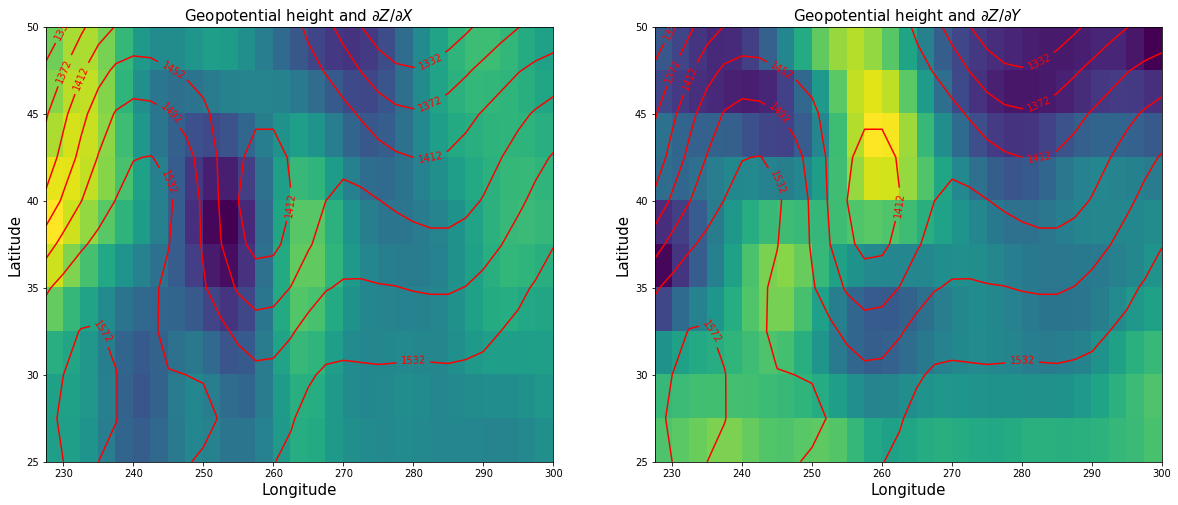

In [166]:
# Plot parameters. The 
hgt_contours = np.arange(hgt.min(), hgt.max() + 1, 40)
pres_contours = np.arange(pres.min(), pres.max()+ 1, 2)


# Plot the wind field
fig, ax = plt.subplots(ncols=2, figsize=(20,8))
X, Y = np.meshgrid(lon_sel, lat_sel)
ax[0].pcolormesh(X,Y,DZDX)
# Plot the geopotential height surface
C1 = ax[0].contour(X, Y, hgt, levels=hgt_contours, colors='r')
plt.clabel(C1, fmt='%1.f')

ax[1].pcolormesh(X,Y,DZDY)
# Plot the geopotential height surface
C1 = ax[1].contour(X, Y, hgt, levels=hgt_contours, colors='r')
plt.clabel(C1, fmt='%1.f')


ax[0].set_xlabel('Longitude', fontsize=15)
ax[0].set_ylabel('Latitude', fontsize=15)
ax[0].set_title('Geopotential height and $\partial Z/\partial X$', fontsize=15)

ax[1].set_xlabel('Longitude', fontsize=15)
ax[1].set_ylabel('Latitude', fontsize=15)
ax[1].set_title('Geopotential height and $\partial Z/\partial Y$', fontsize=15)

The last thing that we need is an array with the Coriolis parameter, $2 \Omega \sin \phi$.

In [170]:
Omega = 7.292e-5
f = 2*Omega*np.deg2rad(Y)

With that in place, we have the components for computing geostrophic wind!

In [173]:
g = 9.8
ugwnd = -g/f*DZDY
vgwnd = g/f*DZDX

Text(0.5, 1.0, 'Ageostrophic wind, surface pressure, and geopotential height')

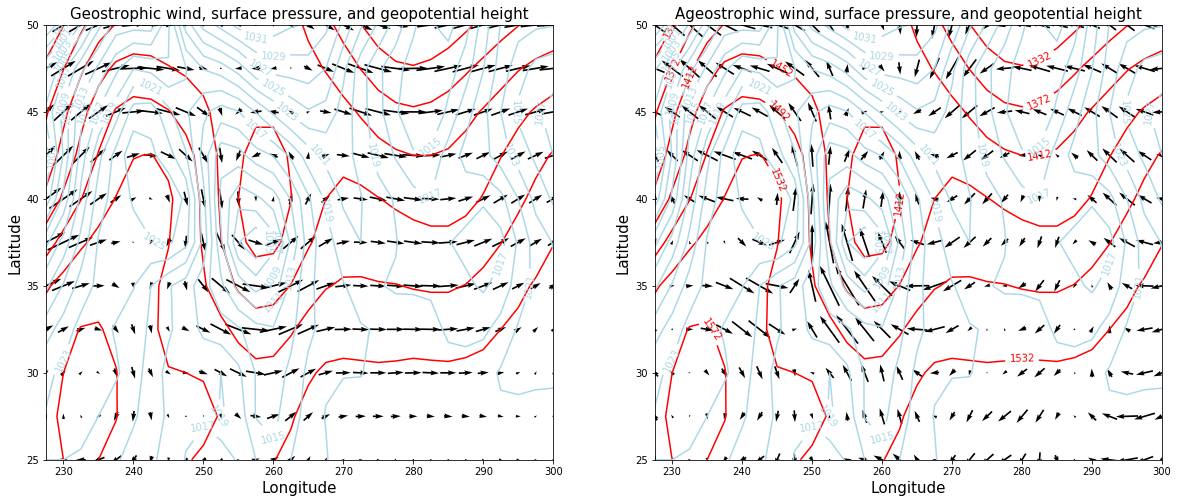

In [176]:
# Plot the wind field
fig, ax = plt.subplots(ncols=2, figsize=(20,8))
X, Y = np.meshgrid(lon_sel, lat_sel)
Q0 = ax[0].quiver(X, Y, ugwnd, vgwnd, pivot='mid')
# Plot the geopotential height surface
C0 = ax[0].contour(X, Y, hgt, levels=hgt_contours, colors='r')
plt.clabel(C1, fmt='%1.f')
C1 = ax[0].contour(X, Y, pres, levels=pres_contours, colors='lightblue')
ax[0].clabel(C1, fmt='%1.f')


Q1 = ax[1].quiver(X, Y, uwnd-ugwnd, vwnd-vgwnd, pivot='mid')
# Plot the geopotential height surface
C2 = ax[1].contour(X, Y, hgt, levels=hgt_contours, colors='r')
plt.clabel(C2, fmt='%1.f')
C3 = ax[1].contour(X, Y, pres, levels=pres_contours, colors='lightblue')
ax[1].clabel(C3, fmt='%1.f')


ax[0].set_xlabel('Longitude', fontsize=15)
ax[0].set_ylabel('Latitude', fontsize=15)
ax[0].set_title('Geostrophic wind, surface pressure, and geopotential height', fontsize=15)

ax[1].set_xlabel('Longitude', fontsize=15)
ax[1].set_ylabel('Latitude', fontsize=15)
ax[1].set_title('Ageostrophic wind, surface pressure, and geopotential height', fontsize=15)

# Alternate version if you have Cartopy installed

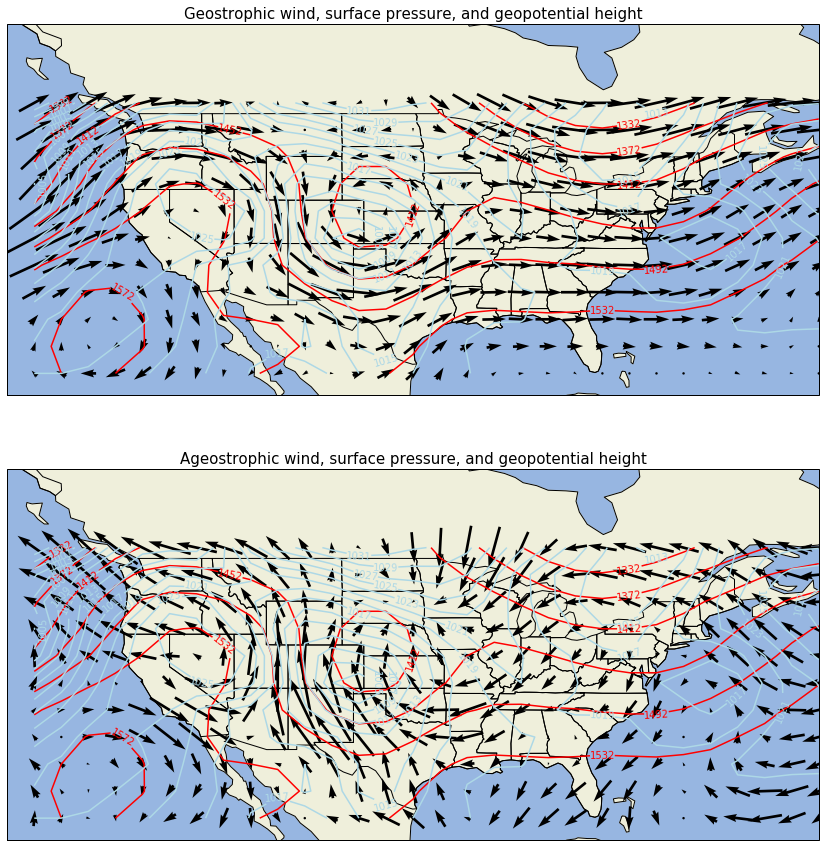

In [198]:
import cartopy.crs as ccrs
import cartopy.feature as cf

fig, ax = plt.subplots(nrows=2, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(20,15))
for axis in ax:
    axis.set_extent([minlon, maxlon, minlat, maxlat])
    axis.add_feature(cf.COASTLINE)
    axis.add_feature(cf.STATES)
    axis.add_feature(cf.OCEAN)
    axis.add_feature(cf.LAND)

Q0 = ax[0].quiver(X, Y, ugwnd, vgwnd, pivot='mid')
# Plot the geopotential height surface
C0 = ax[0].contour(X, Y, hgt, levels=hgt_contours, colors='r')
ax[0].clabel(C0, fmt='%1.f')
C1 = ax[0].contour(X, Y, pres, levels=pres_contours, colors='lightblue')
ax[0].clabel(C1, fmt='%1.f')


Q1 = ax[1].quiver(X, Y, uwnd-ugwnd, vwnd-vgwnd, pivot='mid')
# Plot the geopotential height surface
C2 = ax[1].contour(X, Y, hgt, levels=hgt_contours, colors='r')
plt.clabel(C2, fmt='%1.f')
C3 = ax[1].contour(X, Y, pres, levels=pres_contours, colors='lightblue')
ax[1].clabel(C3, fmt='%1.f')


ax[0].set_xlabel('Longitude', fontsize=15)
ax[0].set_ylabel('Latitude', fontsize=15)
ax[0].set_title('Geostrophic wind, surface pressure, and geopotential height', fontsize=15)

ax[1].set_xlabel('Longitude', fontsize=15)
ax[1].set_ylabel('Latitude', fontsize=15)
ax[1].set_title('Ageostrophic wind, surface pressure, and geopotential height', fontsize=15)

